In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

In [ ]:
# Directory paths
train_dir = '/content/drive/MyDrive/Dataset/Train'
val_dir = '/content/drive/MyDrive/Dataset/Validation'

In [ ]:

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5450 images belonging to 10 classes.
Found 1367 images belonging to 10 classes.


In [ ]:
# Load MobileNetV2 with pre-trained weights and exclude the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

In [ ]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('mobilenetv2_best.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
171/171 [==============================] - 363s 2s/step - loss: 0.0900 - accuracy: 0.9714 - val_loss: 0.0426 - val_accuracy: 0.9846
Epoch 2/10
171/171 [==============================] - 367s 2s/step - loss: 0.0720 - accuracy: 0.9752 - val_loss: 0.0343 - val_accuracy: 0.9890
Epoch 3/10
171/171 [==============================] - 358s 2s/step - loss: 0.0737 - accuracy: 0.9771 - val_loss: 0.0224 - val_accuracy: 0.9905
Epoch 4/10
171/171 [==============================] - 369s 2s/step - loss: 0.0550 - accuracy: 0.9815 - val_loss: 0.0157 - val_accuracy: 0.9920
Epoch 5/10
171/171 [==============================] - 372s 2s/step - loss: 0.0688 - accuracy: 0.9739 - val_loss: 0.0203 - val_accuracy: 0.9949
Epoch 6/10
171/171 [==============================] - 384s 2s/step - loss: 0.0551 - accuracy: 0.9817 - val_loss: 0.0475 - val_accuracy: 0.9839
Epoch 7/10
171/171 [==============================] - 405s 2s/step - loss: 0.0648 - accuracy: 0.9778 - val_loss: 0.0304 - val_accuracy: 0.9912

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

43/43 [==============================] - 65s 1s/step - loss: 0.0481 - accuracy: 0.9824
Validation Loss: 0.048052266240119934
Validation Accuracy: 0.9824433326721191


In [ ]:
model.save('/content/drive/MyDrive/Dataset/mobilenetv2_final.h5')

print("Model saved to disk.")

Model saved to disk.


Found 1367 images belonging to 10 classes.
43/43 [==============================] - 70s 2s/step - loss: 0.0481 - accuracy: 0.9824
Test Loss: 0.04805225878953934
Test Accuracy: 0.9824433326721191


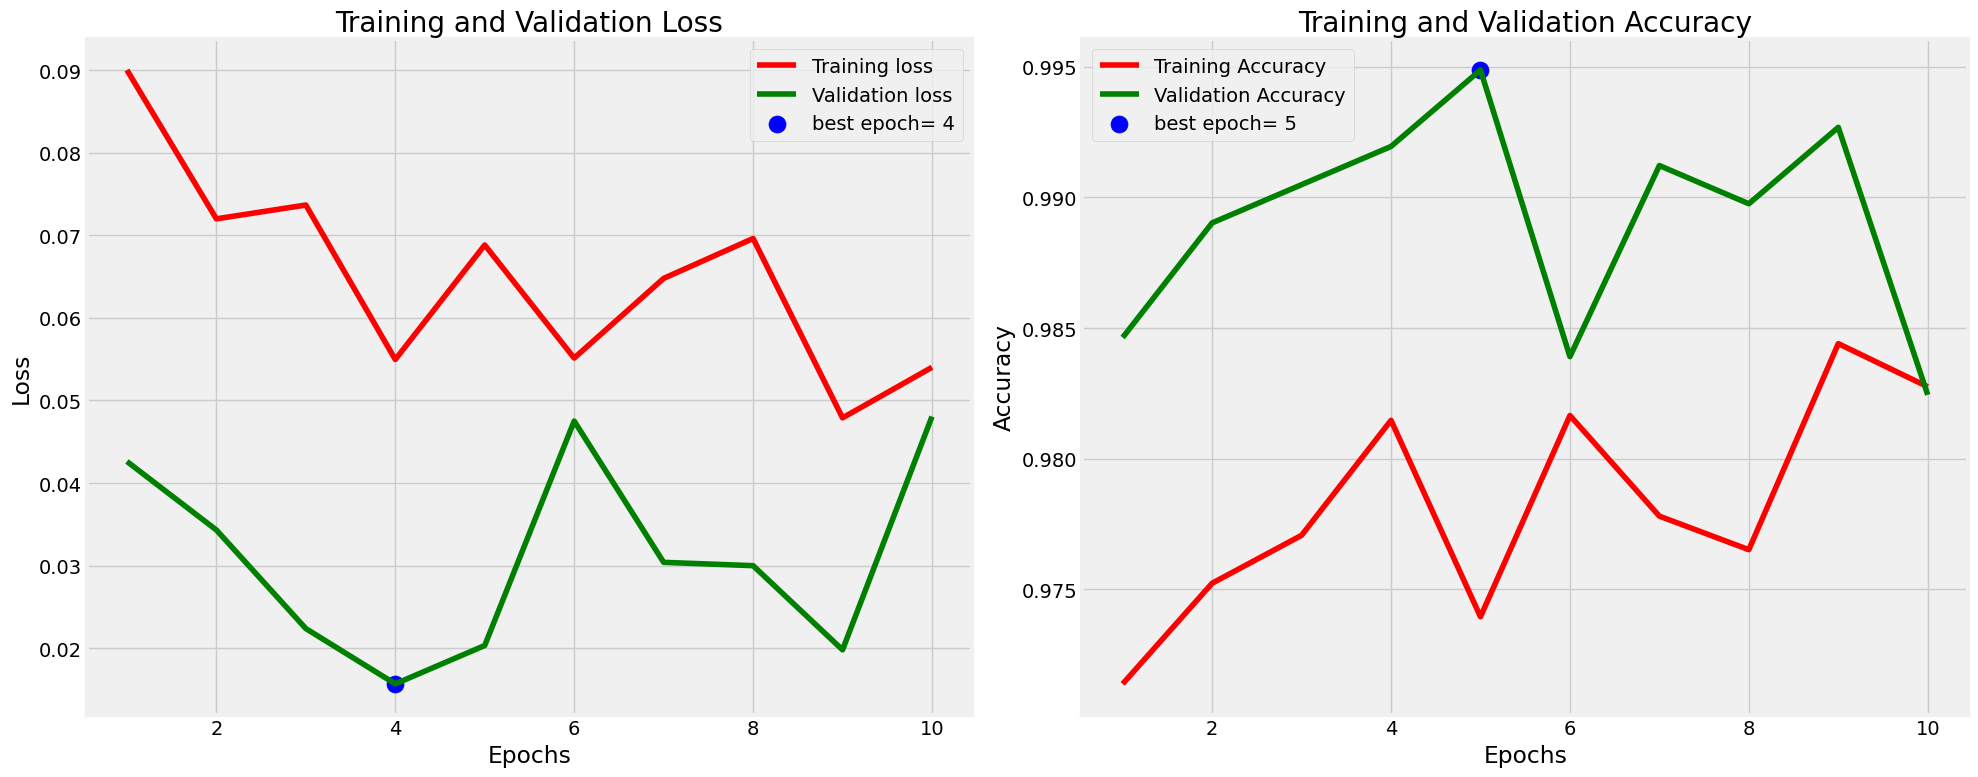

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load and prepare the test data
test_dir = '/content/drive/MyDrive/Dataset/Test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training metrics and log history of training
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Found 1367 images belonging to 10 classes.
43/43 [==============================] - 69s 2s/step
[[129   0   0   0   0   0   0   0   0   0]
 [  0 179   0   0   0   0   0   0   0   0]
 [  5   0 121   0   0   0   1   1   0   0]
 [  4   1   0 120   0   0   0   0   3   0]
 [  0   0   0   0 127   0   2   0   0   0]
 [  0   0   0   0   0 138   0   0   0   0]
 [  0   0   0   0   0   0 150   0   0   0]
 [  0   0   0   0   0   0   0 129   0   0]
 [  0   0   0   0   0   0   0   0 129   0]
 [  1   0   0   0   0   1   4   1   0 121]]


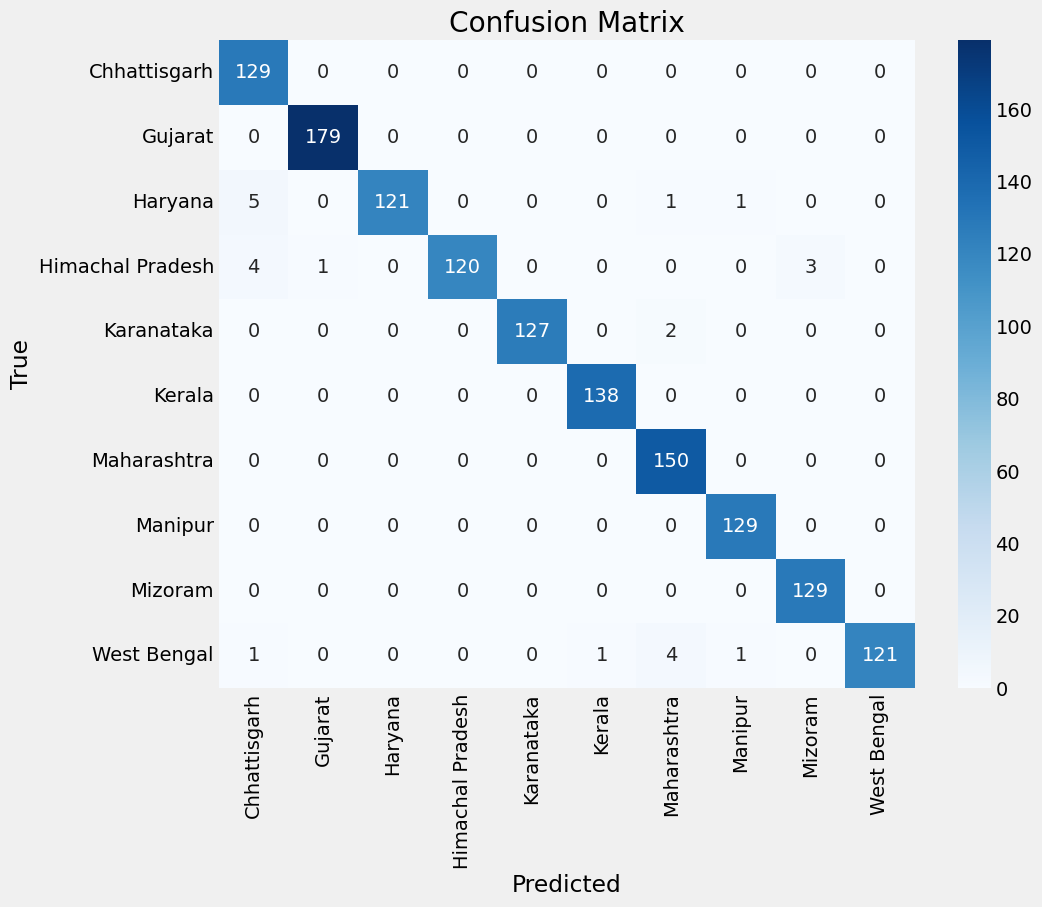

                  precision    recall  f1-score   support

    Chhattisgarh       0.93      1.00      0.96       129
         Gujarat       0.99      1.00      1.00       179
         Haryana       1.00      0.95      0.97       128
Himachal Pradesh       1.00      0.94      0.97       128
      Karanataka       1.00      0.98      0.99       129
          Kerala       0.99      1.00      1.00       138
     Maharashtra       0.96      1.00      0.98       150
         Manipur       0.98      1.00      0.99       129
         Mizoram       0.98      1.00      0.99       129
     West Bengal       1.00      0.95      0.97       128

        accuracy                           0.98      1367
       macro avg       0.98      0.98      0.98      1367
    weighted avg       0.98      0.98      0.98      1367



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/Dataset/mobilenetv2_final.h5')

# Prepare the test data
test_dir = '/content/drive/MyDrive/Dataset/Test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the true labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Make predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/mobilenetv2_final.h5')

# Define the preprocessing function
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

# Load and preprocess the image
img_path = '/content/drive/MyDrive/Dataset/Test11/B_2__11zon.jpg'
img_array = preprocess_image(img_path)

# Predict the spice
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Manually define class indices
class_indices = {
    0: 'Chhattisgarh',
    1: 'Gujarat',
    2: 'Haryana',
    3: 'Himachal Pradesh',
    4: 'Karanataka',
    5: 'Kerala',
    6: 'Maharashtra',
    7: 'Manipur',
    8: 'Mizoram',
    9: 'West Bengal'
    # Add other classes here in the correct order
}

# Map the predicted class index to the state name
predicted_state = class_indices[predicted_class]

print(f'The predicted state is: {predicted_state}')

1/1 [==============================] - 4s 4s/step
The predicted state is: West Bengal


1/1 [==============================] - 1s 1s/step


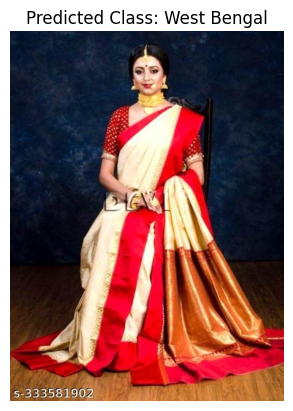

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/mobilenetv2_final.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = ['Chhattisgarh', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Karanataka', 'Kerala', 'Maharashtra', 'Manipur', 'Mizoram', 'West Bengal']  # Replace with your actual class names

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to display the image with the predicted class name
def display_image_with_prediction(img_path):
    predicted_class_name = classify_image(img_path)
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/Dataset/Test11/B_1_1_11zon.jpg'  # Replace with your image path
display_image_with_prediction(image_path)

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Load your trained model or pretrained model
# Assuming you have trained your ResNet50V2 model for spice classification
model = MobileNetV2(weights='imagenet')  # Replace with your actual trained model
test_score = [0.0, 0.98]  # Replace with your actual test scores

# Compile the model to avoid warning about compiled metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model name directly
model_name = 'MobileNetV2'
subject = 'State Wise Costume Image Classification'
acc = test_score[1] * 100  # Assuming test_score[1] is the accuracy
save_path = '/content/drive/MyDrive/Dataset'  # Specify your desired save path

# Create the filename for saving the model
save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.keras'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Create the filename for saving the weights
weight_save_id = f'{model_name}-{subject}-weights.keras'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as /content/drive/MyDrive/Dataset/MobileNetV2-State Wise Costume Image Classification-98.00.keras
weights were saved as /content/drive/MyDrive/Dataset/MobileNetV2-State Wise Costume Image Classification-weights.keras
